# DQCS - usage

In [1]:
import DQCS
from qiskit import Aer, execute
from qiskit import ClassicalRegister
from qiskit import QuantumCircuit
from qiskit import QuantumRegister
import time
import warnings
warnings.filterwarnings('ignore')

#Def. to remove the communication qubits
def get_hist(circuit, qubits, n_shots):
    hist, hist_dict = execute(circuit, Aer.get_backend('qasm_simulator'), shots=n_shots).result().get_counts(), {}
    for key in hist:
        hist_dict[key.split(" ")[0][::-1][0:qubits]] = 0
    for key in hist:
        hist_dict[key.split(" ")[0][::-1][0:qubits]] = hist_dict[key.split(" ")[0][::-1][0:qubits]] + hist[key]
    hist = {k: v / total for total in (sum(hist_dict.values(), 0.0),) for k, v in hist_dict.items()}
    return hist


# 1) Define the qc on one register
print("Generating the distributed quantum circuit 1 (2 qubits)")
n_shots = 1000
time.sleep(2.5)
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
# nodes - define the qubits in each node
nodes = {"1": [0], "2": [1]}
valid_node = 1
qubits = [qubit for sublist in list(nodes.values()) for qubit in sublist]
# Check if nodes are specified for all the qubits
for qubit in range(qc.num_qubits):
    if qubit not in qubits:
        print("please specify the node for qubit", qubit)
        valid_node = 0
if valid_node == 1:
    gate_app, circ = DQCS.DistributedCircuits(qc, nodes).create_circuit()
    circ.measure_all()
    hist_dict = get_hist(circ, qc.num_qubits, n_shots)
    print("Result:", hist_dict)
# 2) Define the qc on multiple registers
print("Generating the distributed quantum circuit 2 (4 qubits)")
q_0 = QuantumRegister(2, 'a')
q_1 = QuantumRegister(2, 'b')
qc = QuantumCircuit(q_0, q_1)
nodes = {"1": [q_0[0], q_0[1]], "2": [q_1[0]], "3": [q_1[1]]}
qc.h(q_0[0])
qc.cx(q_0[0], q_1[1])
# Define empty circuit with communication registers
comm = QuantumRegister(4, 'c')
c = ClassicalRegister(4, 'cl')
circ = QuantumCircuit(q_0, q_1, comm, c)
gate_app, circ = DQCS.CreateDistributedCircuits(qc, c, circ, comm, nodes, 1).create_circuit()
circ.measure_all()
hist_dict = get_hist(circ, qc.num_qubits, n_shots)
print("Result:", hist_dict)

Generating the distributed quantum circuit 1 (2 qubits)
Result: {'00': 0.49, '11': 0.51}
Generating the distributed quantum circuit 2 (4 qubits)
Result: {'0000': 0.482, '1001': 0.518}


# Distributed dynamic quantum phase estimation (3 qubits)

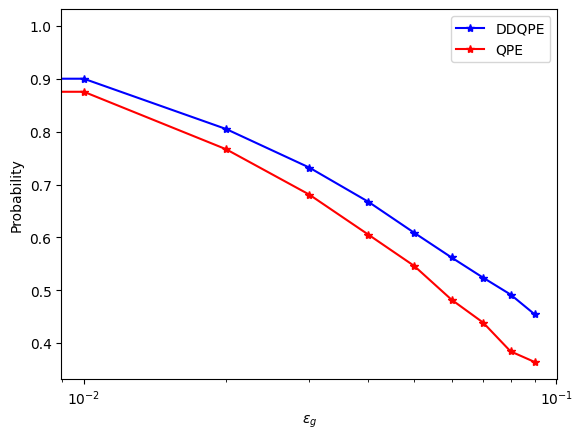

In [ ]:
import DQCS
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile, execute
# from qiskit.providers.aer import noise
from qiskit_aer import noise
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
                              pauli_error, depolarizing_error, thermal_relaxation_error)


def create_initial_circuit(q, c):
    circ = QuantumCircuit(q, c)
    unitary = QuantumCircuit(2)
    unitary.rx(np.pi, 0)
    unitary.ry(np.pi, 1)
    return circ, unitary


def QPE(unitary_circuit, quantum_circuit, num_qubits):
    eig_val, vec = linalg.eig(
        execute(unitary_circuit, Aer.get_backend('unitary_simulator'), shots=1).result().get_unitary(unitary_circuit))
    eig_vec = vec[:, 1]
    norm = np.linalg.norm(eig_vec) ** 2
    quantum_circuit.initialize(eig_vec / norm, [num_qubits, num_qubits + 1])
    quantum_circuit.h([qubit for qubit in range(num_qubits)])
    reps = 1
    for counting_qubit in range(num_qubits):
        for i in range(reps):
            quantum_circuit.compose(unitary_circuit.control(),
                                    qubits=[(num_qubits - 1 - counting_qubit), num_qubits, num_qubits + 1],
                                    inplace=True)
        reps *= 2
    return quantum_circuit


def dynamic_qft(qc, num_qubits, c, inv):
    for i in range(num_qubits):
        qc.h(i)
        qc.p(np.pi / 2, i)
        qc.measure(i, c[i])
        for j in range(i + 1, num_qubits):
            if inv:
                qc.p(-np.pi / 2 ** (j - i), j).c_if(c[i], 1)
            else:
                qc.p(np.pi / 2 ** (j - i), j).c_if(c[i], 1)


def qft_dagger(qc, num_qubits):
    for j in range(num_qubits):
        for m in range(j):
            qc.cp(-np.pi / float(2 ** (j - m)), m, j)
        qc.h(j)


def noise_model(ep_s):
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(noise.depolarizing_error(ep_s, num_qubits=1), ['h', 'id', 'rz', 'rx', 'ry', 'sx', 'sy', 'sz', 'x', 'y', 'z', 'u', 'u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(noise.depolarizing_error(10*ep_s, num_qubits=2), ['cx', 'cp', 'cry', 'crz', 'crx', 'cu', 'cu1', 'cu3'])
#     error_meas = pauli_error([('X',10*ep_s/4), ('I', 1 - 10*ep_s/4)])
#     noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    return noise_model


num_qubits, n_shots = 3, 7000
q = QuantumRegister(num_qubits + 2)
c = ClassicalRegister(num_qubits)
circ, unitary = create_initial_circuit(q, c)
circuit = QPE(unitary, circ, num_qubits)
qft_dagger(circuit, num_qubits)
for i in range(num_qubits):
    circuit.measure(i, i)
circuit =transpile(circuit, basis_gates=['cx', 'h', 'id', 'rz', 'sx', 'x', 'y', 'z'], optimization_level=3)
circ, unitary = create_initial_circuit(q, c)
circ = QPE(unitary, circ, num_qubits)
gate_app, qc = DQCS.DistributedCircuits(transpile(circ, basis_gates=['u', 'h', 'cx'], optimization_level=3),
                                        {"1": [i for i in range(num_qubits)],
                                         "2": [num_qubits, num_qubits + 1]}).create_circuit()

q, c = QuantumRegister(qc.num_qubits, 'q'), ClassicalRegister(4, 'c')
circuit_0 = QuantumCircuit(q, c)
circuit_0.append(qc.to_instruction(), q,c)
dynamic_qft(circuit_0, num_qubits, c, True)
# print(execute(circuit_0, Aer.get_backend('qasm_simulator'), shots=n_shots).result().get_counts())
val = '100'
count, counts = [], []
x  = []
for i in range(0, 10):
    count.append(execute(circuit, Aer.get_backend('qasm_simulator'), basis_gates=noise_model(i * 0.001).basis_gates,
                         noise_model=noise_model(i * 0.001), shots=n_shots).result().get_counts()[val]/n_shots)
    counts.append(execute(circuit_0, Aer.get_backend('qasm_simulator'), basis_gates=noise_model(i * 0.001).basis_gates,
                          noise_model=noise_model(i * 0.001), shots=n_shots).result().get_counts()['0' + val]/n_shots)
    x.append(i*0.001*10) #y axis is ep_g thats defined in noise model as 10*ep_s

plt.semilogx(x, counts, "b*-")
plt.semilogx(x, count, "r*-")
plt.xlabel(r"$\epsilon_g$")
plt.ylabel("Probability")
plt.legend(["DDQPE", "QPE"])
plt.show()

# Distributed dynamic quantum phase estimation (5 qubits)

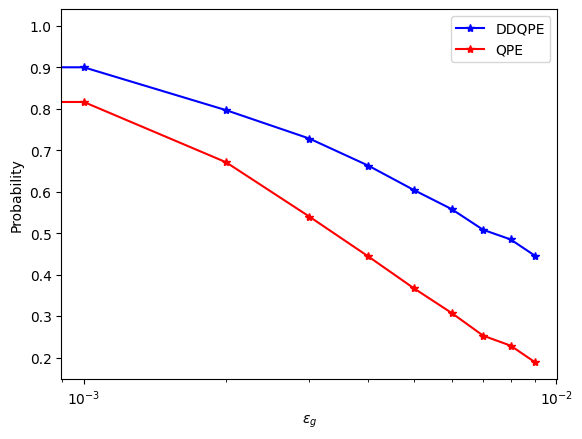

In [3]:
import DQCS
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile, execute
from qiskit.providers.aer import noise


num_qubits, n_shots = 5, 7000
q = QuantumRegister(num_qubits + 2)
c = ClassicalRegister(num_qubits)
circ, unitary = create_initial_circuit(q, c)
circuit = QPE(unitary, circ, num_qubits)
qft_dagger(circuit, num_qubits)
for i in range(num_qubits):
    circuit.measure(i, i)
circuit =transpile(circuit, basis_gates=['u', 'h', 'cx'], optimization_level=3)
circ, unitary = create_initial_circuit(q, c)
circ = QPE(unitary, circ, num_qubits)
gate_app, qc = DQCS.DistributedCircuits(transpile(circ, basis_gates=['u', 'h', 'cx'], optimization_level=3),
                                        {"1": [i for i in range(num_qubits)],
                                         "2": [num_qubits, num_qubits + 1]}).create_circuit()

#set number of classical registers in DQCS.py to number of classical registers (7+2)
q, c = QuantumRegister(qc.num_qubits, 'q'), ClassicalRegister(qc.num_qubits, 'c')
circuit_0 = QuantumCircuit(q, c)
circuit_0.append(qc.to_instruction(), q,c)
dynamic_qft(circuit_0, num_qubits, c, True)
val = '10000'
count, counts = [], []
x  = []
for i in range(0, 10):
    count.append(execute(circuit, Aer.get_backend('qasm_simulator'), basis_gates=noise_model(i * 0.001, i * 0.001).basis_gates,
                         noise_model=noise_model(i * 0.001, i * 0.001), shots=n_shots).result().get_counts()[val]/n_shots)
    counts.append(execute(circuit_0, Aer.get_backend('qasm_simulator'), basis_gates=noise_model(i * 0.001, i * 0.001).basis_gates,
                          noise_model=noise_model(i * 0.001, i * 0.001), shots=n_shots).result().get_counts()['0000' + val]/n_shots)
    x.append(i*0.001)


plt.semilogx(x, counts, "b*-")
plt.semilogx(x, count, "r*-")
plt.xlabel(r"$\epsilon_g$")
plt.ylabel("Probability")
plt.legend(["DDQPE", "QPE"])
plt.show()

# Dynamic quantum circuit creator

In [20]:
#This python function, obtains the dynamic quantum circuit implementation (if present) for any input quantum circuit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile, execute
import numpy as np
from numpy import linalg
def dynamic_quantum_circuit_create(qc):
    q, c = QuantumRegister(qc.num_qubits), ClassicalRegister(qc.num_qubits)
    circuit, meas, x, qubits, param,qc_gates, qc_dynamic = QuantumCircuit(q, c), [0]*qc.num_qubits, [], [], [], [], []
    [[x.append(gate.name), qubits.append(qubit[0].index if gate.name not in ['cp', 'cx', 'cu'] else [q.index for q in qubit]), param.append(gate.params)] for gate, qubit, _ in qc]
    for i in range(len(qubits)):
        if x[i] == 'h':
            circuit.h(qubits[i])
        elif x[i] == 'u':
            circuit.u(param[i][0],param[i][1],param[i][2],qubits[i])
        elif x[i] == 'cx':
            if not any(x[j] in ['h', 'u'] and qubits[i][0] == qubits[j] for j in range(i+1, len(qubits))):
                if meas[qubits[i][0]] == 0:
                    circuit.measure(qubits[i][0], c[qubits[i][0]]), circuit.x(qubits[i][1]).c_if(c[qubits[i][0]], 1)
                    meas[qubits[i][0]] = 1
                else:
                    circuit.x(qubits[i][1]).c_if(c[qubits[i][0]], 1)
            else:
                circuit.cx(qubits[i][0], qubits[i][1])
        elif x[i] == 'cp':
            if not any(x[j] in ['h', 'u'] and qubits[i][0] == qubits[j] for j in range(i+1, len(qubits))):
                if meas[qubits[i][0]] == 0:
                    circuit.measure(qubits[i][0], c[qubits[i][0]]), circuit.p(param[i][0], qubits[i][1]).c_if(c[qubits[i][0]], 1)
                    meas[qubits[i][0]] = 1
                else:
                    circuit.p(param[i][0], qubits[i][1]).c_if(c[qubits[i][0]], 1)
            else:
                circuit.cp(param[i][0], *qubits[i])
        elif x[i] == 'cu':
            if not any(x[j] in ['h', 'u'] and qubits[i][0] == qubits[j] for j in range(i+1, len(qubits))):
                if meas[qubits[i][0]] == 0:
                    circuit.measure(qubits[i][0], c[qubits[i][0]]), circuit.u(param[i][0],param[i][1],param[i][2], qubits[i][1]).c_if(c[qubits[i][0]], 1)
                    meas[qubits[i][0]] = 1
                else:
                    circuit.u(param[i][0],param[i][1],param[i][2], qubits[i][1]).c_if(c[qubits[i][0]], 1)
            else:
                circuit.cu(param[i][0], *qubits[i])
    circuit.measure(circuit.num_qubits - 1, c[circuit.num_qubits - 1]), [[qc_gates.append(1 if gate.name in ['cp', 'cx', 'cu'] else [0])] for gate, qubit, _ in qc], [[qc_dynamic.append(1 if gate.name in ['cp', 'cx', 'cu'] else [0])] for gate, qubit, _ in circuit], print("The number of two-qubit gates in the quantum circuit is {}, dynamic quantum circuit is {}" .format(qc_gates.count(1), qc_dynamic.count(1)))
    return circuit
def qft_dagger(qc, num_qubits):
    [([qc.cp(-np.pi/float(2**(j-m)), m, j) for m in range(j)], qc.h(j)) for j in range(num_qubits)]
def create_circuit_test(qc):
    qc.h(0), qc.cx(0,1), qc.u(np.pi/2,0,0, 1), qc.cu(np.pi/2,0,0,0,1,2)
def create_circuit_qpe(num_qubits):
    q,c = QuantumRegister(num_qubits + 2), ClassicalRegister(num_qubits)
    qc,unitary = QuantumCircuit(q, c),QuantumCircuit(2)
    unitary.ry(np.pi, 0), unitary.rx(np.pi, 1)
    eig_val, vec = linalg.eig(execute(unitary, Aer.get_backend('unitary_simulator'), shots=1).result().get_unitary(unitary))
    eig_vec,reps = vec[:, 1],1
    norm = np.linalg.norm(eig_vec)**2
    qc.initialize(eig_vec / norm, [num_qubits, num_qubits + 1]), qc.h([qubit for qubit in range(num_qubits)])
    for counting_qubit in range(num_qubits):
        for i in range(reps):
            qc.compose(unitary.control(), qubits=[(num_qubits - 1 - counting_qubit), num_qubits, num_qubits + 1], inplace=True)
            reps *= 2
    return transpile(qc, basis_gates=['u', 'h', 'cx'], optimization_level=3)
#1 - Quantum Fourier transform
circuit = QuantumCircuit(3)
qft_dagger(circuit, circuit.num_qubits)
circuit = dynamic_quantum_circuit_create(circuit)
#2 - Quantum phase estimation
circuit = create_circuit_qpe(3)
qft_dagger(circuit, circuit.num_qubits)
circuit = dynamic_quantum_circuit_create(circuit)
#3 - User defined quantum circuit
circuit = QuantumCircuit(3)
create_circuit_test(circuit)
circuit = dynamic_quantum_circuit_create(circuit)

The number of two-qubit gates in the quantum circuit is 3, dynamic quantum circuit is 0
The number of two-qubit gates in the quantum circuit is 17, dynamic quantum circuit is 7
The number of two-qubit gates in the quantum circuit is 2, dynamic quantum circuit is 0
